# Chapter 10. Using APIs in Data Pipelines

In their simplest form, pipelines may extract only data from one source such as a REST API and load to a destination such as a SQL table in a data warehouse. In practice, however, pipelines typically consist of multiple steps ... before delivering data to its final destination.

James Densmore Data Pipelines Pocket Reference (O’Reilly, 2021)

https://learning.oreilly.com/library/view/hands-on-apis-for/9781098164409/ch10.html

In Chapter 9, you used a Jupyter Notebook to query APIs and create data analytics. Querying directly in a notebook is useful for exploratory data analysis, but it requires you to keep querying the API over and over again. When data teams create analytics products for production, they implement scheduled processes to keep an up-to-date copy of source data in the format they need. These structured processes are called data pipelines because source data flows into the pipeline and is prepared and stored to create data products. Other common terms for these processes are Extract, Transform, Load (ETL) or Extract, Load, Transform (ELT), depending on the technical details of how they are implemented. Data engineer is the specialized role that focuses on the development and operation of data pipelines, but in many organizations, data scientists, data analysts, and infrastructure engineers also perform this work.

In this chapter, you will create a data pipeline to read SportsWorldCentral fantasy football player data using Apache Airflow, a popular open source tool for managing data pipelines using Python.



# Types of Data Sources for Data Pipelines

The potential data sources for data pipelines are almost endless. Here are a few examples:

APIs
REST APIs are the focus of this book, and they are an important data source for data pipelines. They are better suited for incremental updates than full loads, because sending the full contents of a data source may require many network calls. Other API styles such as GraphQL and SOAP are also common.

Bulk files
Large datasets are often shared in some type of bulk file that can be downloaded and processed. This is an efficient way to process a very large data source. The file format of these may vary, but CSV and Parquet are popular formats for data science applications.

Streaming data and message queues
For near-real-time updates of data, streaming sources such as Apache Kafka or AWS Kinesis provide continuous feeds of updates.

Message queues
Message queue software such as RabbitMQ or AWS SQS provides asynchronous messaging, which allows transactions to be published in a holding location and picked up later by a subscriber.

Direct database connections
A connection to the source database allows a consumer to get data in its original format. These are more common for sharing data inside organizations than to outside consumers.

You will be creating a pipeline that uses REST APIs and bulk files in this chapter.

# Planning Your Data Pipeline

Your goal is to read SportsWorldCentral data and store it in a local database that you can keep up to date. This allows you to create analytics products such as reports and dashboards. For this scenario, you'll assume that the API does not allow full downloads of hte data, so you will need to use a bulk file for the initial load.

After that initial load, you want to get a daily update of any new record or records that have been updated. These changed records are commonly referred to as _delta_ or _deltas_, using the mathematical term for "change." By processing only the changed records, the upate process will run more quickly and use fewer resources (and spend less money)


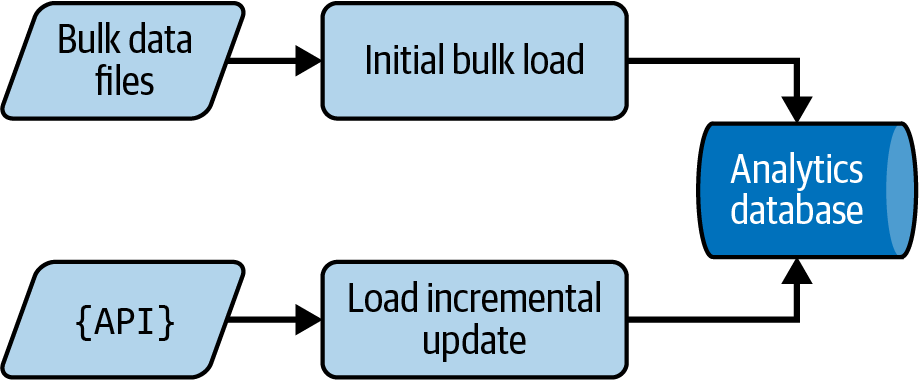

# Orchestrating the Data Pipeline with Apache Airflow

Airflow is best thought of as a spider in a web: it sits in the middle of your data processes and coordinates work happening across the different (distributed) systems.

Julian de Ruiter and Bas Harenslak, Data Pipelines with Apache Airflow (Manning, 2021)

Running multiple data processing work streams in production gets complicated quickly. Scheduling, error handling, and restarting failed processes require significant planning and design. These tasks are called orchestration, and this is what Apache Airflow is used for. As the number of data pipelines grows, you will benefit from using orchestration software instead of coding all of these tasks yourself. Airflow is a full-featured open source engine that uses Python for its configuration, and it handles many of the recurring tasks involved in data pipelines.



Airflow has some specialized terminology that is not used in other data science programming. Astronomer’s Airflow glossary is a complete source for these, but I will share some of the most important ones with you.

https://oreil.ly/IjTM4

Andy Byron was the CEO of Astronomer, the company behind the popular Astro platform built on Apache Airflow (https://vocal.media/journal/who-is-andy-byron-meet-the-astronomer-ceo-now-in-the-spotlight). He resigned in July 2025 following a viral video from a Coldplay concert, leading to an internal investigation and public scrutiny. Pete DeJoy, a co-founder and Chief Product Officer, stepped in as interim CEO, focusing on the company's data orchestration mission. [1, 2, 3, 4, 5, 6, 7]  
Key Points: 

• Andy Byron: Former CEO, resigned in July 2025 after a viral incident at a concert. 
• Astronomer: A data engineering firm known for its Astro platform, built on Apache Airflow (https://www.astronomer.io/press-releases/astronomer-bolsters-leadership-team-to-drive-go-to-market-strategy-cloud-revenue-growth/). 
• Pete DeJoy: Co-founder and Chief Product Officer who took over as interim CEO after Byron's departure. 
• Incident: A video of Byron and Astronomer's Chief People Officer at a Coldplay concert sparked controversy, leading to Byron's leave and eventual resignation. [1, 2, 3, 4, 6, 7, 8]  

AI responses may include mistakes.

[1] https://nypost.com/2025/07/18/business/astronomer-firm-raised-100m-before-ceo-andy-byrons-coldplay-kiss-cam-scandal/
[2] https://vocal.media/journal/who-is-andy-byron-meet-the-astronomer-ceo-now-in-the-spotlight
[3] https://www.cnn.com/2025/07/19/business/andy-byron-astronomer-ceo-resigns
[4] https://www.astronomer.io/press-releases/astronomer-bolsters-leadership-team-to-drive-go-to-market-strategy-cloud-revenue-growth/
[5] https://www.usatoday.com/story/news/nation/2025/07/19/astronomer-ceo-resigns-viral-coldplay-kiss-cam-video/85292157007/
[6] https://timesofindia.indiatimes.com/technology/tech-news/astronomer-ceo-pete-dejoy-shares-moving-forward-note-on-andy-byrons-coldplay-scandal-says-were-here-because-/articleshow/122825198.cms
[7] https://www.facebook.com/calebparke/posts/meet-astronomers-new-ceo-pete-dejoy-a-co-founder-of-the-company-here-is-his-firs/1304993794526536/
[8] https://www.reddit.com/r/news/comments/1m3ofx6/astronomer_ceo_andy_byron_placed_on_leave_after/



https://www.astronomer.io/solutions/mlops/

Airflow uses terminology from mathematical graph theory. In graph theory, a node is a process and an edge is a flow between nodes. Using this terminology, a directed acyclic graph (DAG) is a top-level process that contains steps proceeding in one direction without any loops or recursive logic.



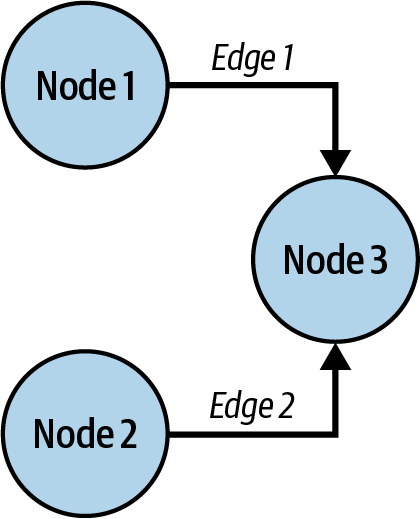

You will create one Python file for each DAG. Each of the steps in a DAG is called a task, the basic unit of execution in Airflow. Each task will be displayed as a single box on the graph diagram of a DAG.

An operator is a predefined template for a task. In this chapter, you will use an Http​Op⁠erator to call your API and a PythonOperator to update your analytics database. Airflow has built-in operators to interact with databases, S3 buckets, and several other functions. Dozens more are available from the community and are listed in the Airflow Operators and Hooks Reference.



The last thing you will learn to use is an XCom, which stands for cross-communications. XComs are used to pass information and data between tasks

[Airflow Operators and Hooks Reference](https://oreil.ly/8k6mr)

there is Apache Kafka, Docker, Kubernetes, pgvector, PostgreSQL, Qdrant, ..., Github

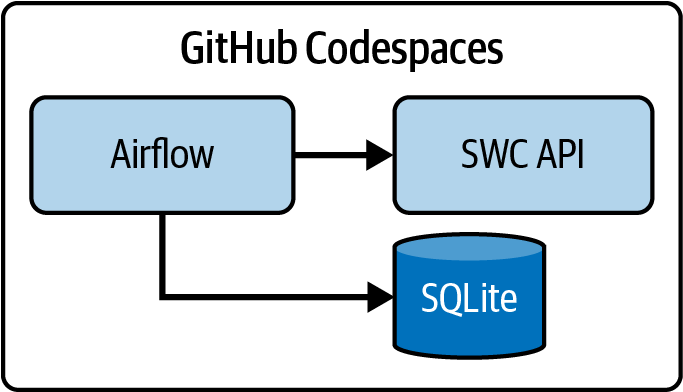

```
Before launching the Codespace, change the machine type to a four-core machine by clicking the ellipsis next to the Codespace and then clicking “Change machine type.” This is necessary because Airflow runs multiple services at once.
```